In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl

import model.networks as networks
import model.vdm_model as vdm_model
import utils.utils as utils
import data.constants as constants

device="cuda:1" if torch.cuda.is_available() else "cpu"
print(device)

cuda:1


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300

In [ ]:
def load_model(dataset = 'Astrid',
        cropsize = 128,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = False,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,128,128,128),
            noise_schedule=noise_schedule,
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    
    ckpt = '/opt/data/private/wangjuntong/code/redshift/debiasing_redshift_0to1/e64e296441fa43d0a5e4cd0782de5fc8/checkpoints/epoch=513-step=3084-val_loss=1.003.ckpt'
    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [ ]:
vdm = load_model()

In [3]:
# Load data
mass_mstar = np.load('Grids_Mcdm_Astrid_CV_128_z=0.0.npy')
mass_cdm = np.load('Grids_Mcdm_Astrid_CV_128_z=1.0.npy')
mass_mstar = np.log10(mass_mstar + 1)
mass_cdm = np.log10(mass_cdm + 1)

# 从constants中获取归一化参数
mean_input = constants.norms['Astrid'][0]
std_input = constants.norms['Astrid'][1]
mean_target = constants.norms['Astrid'][2]
std_target = constants.norms['Astrid'][3]

# 将numpy数组转换为torch张量，并应用归一化
# 注意unsqueeze操作可能不再需要，因为3D数据已经具有额外的深度维度
mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1)

# 确保张量的形状正确，这里应该是 (N, C, D, H, W)，其中C=1表示单通道
print("Mass mstar normed shape:", mass_mstar_normed.shape)
print("Mass cdm normed shape:", mass_cdm_normed.shape)

Mass mstar normed shape: torch.Size([27, 1, 128, 128, 128])
Mass cdm normed shape: torch.Size([27, 1, 128, 128, 128])


In [ ]:
def generate_samples(vdm, conditioning, batch_size=1, n=10):

    star = conditioning
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2],star.shape[3])

    maps = [] # n tensors of shape ([batch_size, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            n_sampling_steps=vdm.hparams.n_sampling_steps,
            )
        maps.append(sample)
        
    return maps

In [4]:
idx = 0

In [ ]:
generated_fiducial_normed = torch.vstack(
    generate_samples(
        vdm,
        conditioning=mass_mstar_normed[0].to(device), 
        batch_size=1, 
        n=10,
    )
)
generated_fiducial = generated_fiducial_normed * std_target + mean_target

In [ ]:
# 定义保存路径
generated_fiducial_normed_path = 'summary_statics_generated_fiducial_normed.pt'
generated_fiducial_path = 'summary_statics_generated_fiducial.pt'

# 使用torch.save保存生成的归一化样本和反归一化后的样本
torch.save(generated_fiducial_normed, generated_fiducial_normed_path)
torch.save(generated_fiducial, generated_fiducial_path)


In [4]:
# 使用torch.load加载之前保存的张量

generated_fiducial_normed_path = 'summary_statics_generated_fiducial_normed.pt'
generated_fiducial_path = 'summary_statics_generated_fiducial.pt'

generated_normed = torch.load(generated_fiducial_normed_path)
generated = torch.load(generated_fiducial_path)


In [5]:
halos = {
    (50, 89,63) : 5,
    (50, 46,63) : 4,
    (8, 38,63) : 5,
    (60, 37,63) : 4,
    (18, 92,63) : 7,
}

In [6]:
X, Y ,Z= np.ogrid[:128, :128,:128]
true_masses = []
masks = []
for center, radius in halos.items():
    distance = np.sqrt((X-center[0])**2+(Y-center[1])**2+(Z-center[2])**2)
    cdm_mass = mass_cdm[0].squeeze()
    mask = distance <= radius
    masks.append(mask)
    masked = cdm_mass.copy()
    masked[~mask] = 0
    true_masses.append(np.sum(10 ** masked))

In [7]:
generated_masses = []
for mask in masks:
    generated_mass = []
    for sample in generated:
        masked = sample.squeeze().detach().clone()
        masked[~mask] = 0
        generated_mass.append(torch.sum(10**masked).item())
    generated_masses.append(np.array(generated_mass))

In [9]:
mass_cdm1=mass_cdm[:, :, :, 63]

In [10]:
mass_mstar1=mass_mstar[:, :, :, 3]

In [8]:
colors = ['#935083', '#FB8B6F', '#FFBE62', '#D16580','#00C89E']

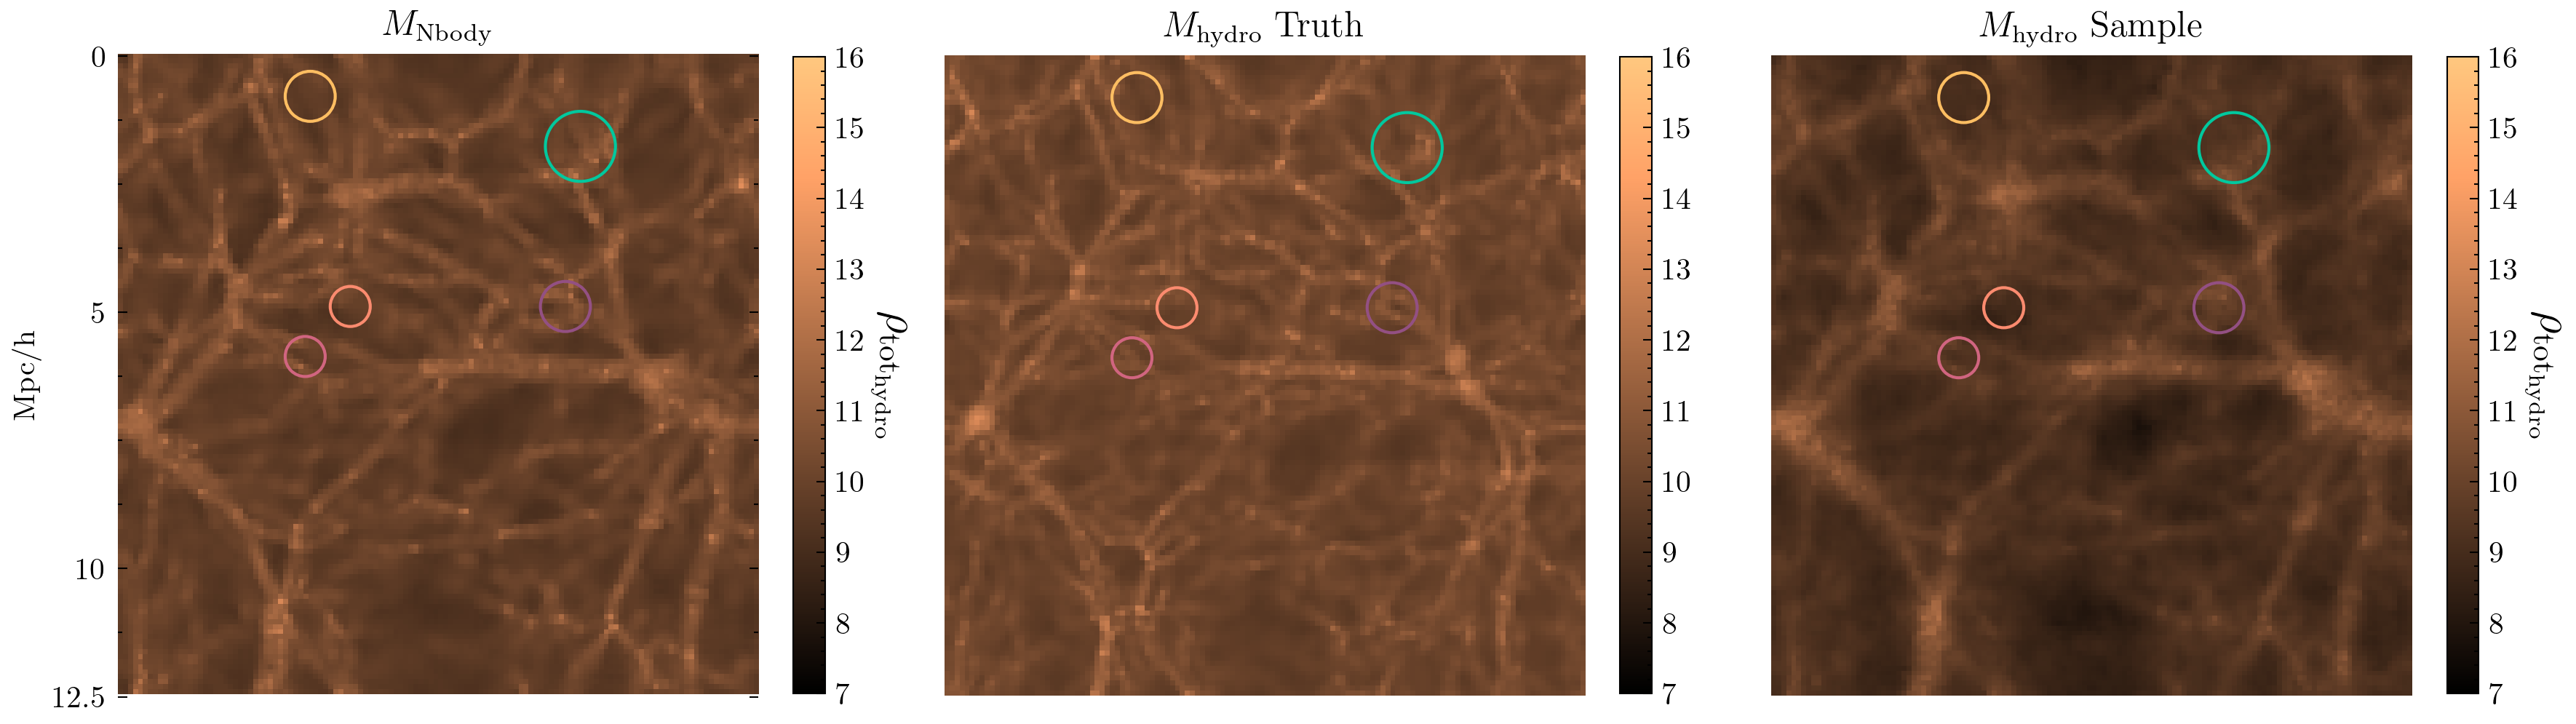

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
mass_mstar_selected = mass_mstar[0].squeeze()
# Select a middle slice from the 3D volume, here the 64th slice along the z-axis
slice_index = 63
fig, axes = plt.subplots(1,3, figsize=(12,4))

img = axes[0].imshow(mass_mstar[0, slice_index, :, :], cmap='copper',vmin=7,vmax=16)  # Adjusted for correct indexing
cbar = fig.colorbar(img, ax=axes[0], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\rho_{\mathrm{tot_{hydro}}}$", rotation=270, fontsize=15)

img = axes[1].imshow(mass_cdm[0, slice_index, :, :], cmap='copper',vmin=7,vmax=16)
fig.colorbar(img, ax=axes[1], fraction=0.045)

img = axes[2].imshow(generated[9, 0,slice_index, :, :].cpu(), cmap='copper',vmin=7,vmax=16)
cbar = fig.colorbar(img, ax=axes[2], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\rho_{\mathrm{tot_{hydro}}}$', rotation=270, fontsize=15)

for i, (center, radius) in enumerate(halos.items()):
    axes[0].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i], 
             fill=False,
             lw=1))
    axes[1].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))
    axes[2].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))

axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks([])
axes[0].set_yticks([0., 51.2, 102.4, 128], labels=["0", "5", "10", "12.5"])
axes[0].set_ylabel("Mpc/h")        
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title(r"$M_{\mathrm{Nbody}}$")
axes[1].set_title(r"$M_{\mathrm{hydro}}$ Truth")
axes[2].set_title(r"$M_{\mathrm{hydro}}$ Sample") 
plt.tight_layout()

Text(0.5, 1.0, 'Probability distribution of the halo mass')

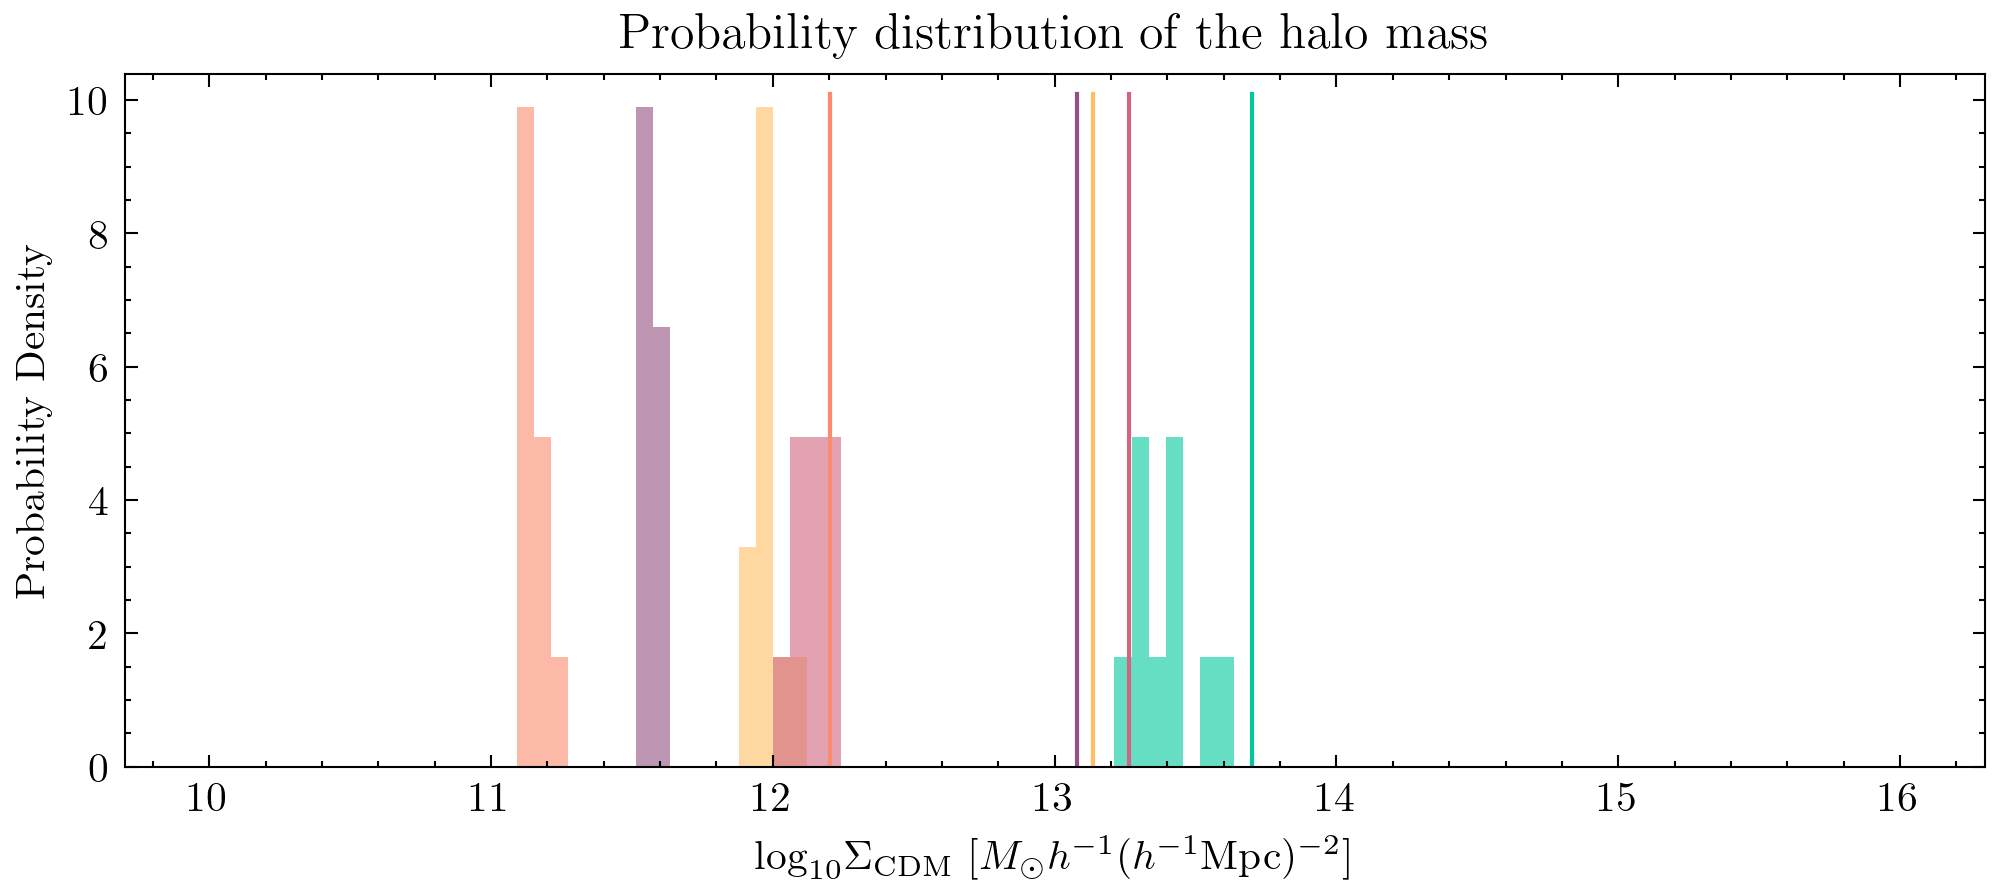

In [10]:
fig, ax = plt.subplots(figsize=(8,3))
n_bins = 25
mbin = np.linspace(10,16,100)
for i in range(len(generated_masses)):
  ax.hist(np.log10(generated_masses[i]), bins=mbin, color=colors[i], alpha=0.6, histtype='stepfilled', density=True,
            )
  ax.axvline(np.log10(true_masses[i]), 0, 0.97, color=colors[i])

ax.set_xlabel(r'$\mathrm{log}_{10} \Sigma_{\mathrm{CDM}}$ ' + '$[M_{\odot} h^{-1} ( h^{-1} \mathrm{Mpc})^{-2}]$')
ax.set_ylabel('Probability Density')
ax.set_title('Probability distribution of the halo mass')